In [ ]:
from __future__ import print_function
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn .functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialisation des constantes
batch_size = 256
num_classes = 10
epochs= 20
learning_rate = 0.001
encoding_dim = 32

In [ ]:
# Chargement des données
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 104459486.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39807983.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49445137.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19165521.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Autoencoder(nn.Module): # Autoencoder
    def __init__(self): # Constructeur
        super(Autoencoder, self).__init__() # Heritage de la classe nn.Module
        self.encoder = nn.Sequential( # Definition de l'encodeur
            nn.Linear(28, encoding_dim), # Couche lineaire de 28 neurones en entree et encoding_dim en sortie
            nn.ReLU() # Fonction d'activation ReLU
        )
        self.decoder = nn.Sequential( # Definition du decodeur
            nn.Linear(encoding_dim, 28), # Couche lineaire de encoding_dim neurones en entree et 28 en sortie
            nn.Sigmoid() # Fonction d'activation Sigmoid
        )

    def forward(self, x):
        encoded = self.encoder(x) # Encodage de l'entree
        decoded = self.decoder(encoded) # Decodage de l'entree encodee
        return decoded # Renvoie de la sortie decodee

In [ ]:
AE = Autoencoder().to(device)  # Initialisation du reseau de neurones de l'autoencodeur

criterion = nn.MSELoss() # Fonction de cout (erreur quadratique moyenne)
optimizer = optim.Adam(AE.parameters(), lr=learning_rate) # Choix de l'optimiseur Adam

In [ ]:
from torch.cuda import device_count
list_loss_train = [] # Liste des loss pour l'entrainement
list_accuracy_train = [] # Liste des accuracy pour l'entrainement
list_loss_test = [] # Liste des loss pour le test
list_accuracy_test = [] # Liste des accuracy pour le test
seuil = 0.5 # Seuil pour la binarisation

for epoch in range(epochs): # Boucle sur les epochs
    AE.train() # Mode entrainement
    sous_list_loss_train = [] # Liste des loss pour l'entrainement
    sous_valeur_accuracy_train = 0 # Valeur de l'accuracy pour l'entrainement
    for data in mnist_train_loader: # Boucle sur les donnees d'entrainement
        img, _ = data # Recuperation des images
        optimizer.zero_grad() # Remise a zero des gradients
        img = img.to(device) # Passage des images sur le GPU
        output = AE(img) # Passage des images dans le reseau
        loss = criterion(output, img) # Calcul de la loss
        loss.backward() # Calcul des gradients
        optimizer.step() # Mise a jour des poids

        sous_list_loss_train.append(loss.item()) # Ajout de la loss a la liste
        sous_valeur_accuracy_train += ((output > seuil) == (img > seuil)).sum().item() # Ajout de l'accuracy

    total_pixels = img.view(img.size(0), -1).size(1) # Calcul du nombre de pixels
    list_accuracy_train.append(sous_valeur_accuracy_train / (len(mnist_train_set) * total_pixels)) # Ajout de l'accuracy a la liste
    list_loss_train.append(np.mean(sous_list_loss_train)) # Ajout de la loss a la liste

    AE.eval() # Mode evaluation
    with torch.no_grad(): # Pas de calcul de gradient
        sous_list_loss_test = [] # Liste des loss pour le test
        sous_valeur_accuracy_test = 0 # Valeur de l'accuracy pour le test
        for data in mnist_test_loader: # Boucle sur les donnees de test
            img, _ = data # Recuperation des images
            img = img.to(device) # Passage des images sur le GPU
            output = AE(img) # Passage des images dans le reseau
            loss = criterion(output, img) # Calcul de la loss
            sous_list_loss_test.append(loss.item()) # Ajout de la loss a la liste
            sous_valeur_accuracy_test += ((output > seuil) == (img > seuil)).sum().item() # Ajout de l'accuracy

        total_pixels = img.view(img.size(0), -1).size(1) # Calcul du nombre de pixels
        list_accuracy_test.append(sous_valeur_accuracy_test / (len(mnist_test_set) * total_pixels)) # Ajout de l'accuracy a la liste
        list_loss_test.append(np.mean(sous_list_loss_test)) # Ajout de la loss a la liste

    img = img.cpu().data.numpy() # Passage des images sur le CPU
    output = output.cpu().data.numpy() # Passage des images sur le CPU
    print('epoch [{}/{}], loss train:{:.4f}, loss test:{:.4f}, accuracy train:{:.4f}, accuracy test:{:.4f}'.format(epoch + 1, epochs, list_loss_train[-1], list_loss_test[-1], list_accuracy_train[-1], list_accuracy_test[-1]))

epoch [1/20], loss train:0.7779, loss test:0.5470, accuracy train:0.8856, accuracy test:0.9692
epoch [2/20], loss train:0.5120, loss test:0.5026, accuracy train:0.9764, accuracy test:0.9821
epoch [3/20], loss train:0.4878, loss test:0.4904, accuracy train:0.9841, accuracy test:0.9864
epoch [4/20], loss train:0.4796, loss test:0.4854, accuracy train:0.9871, accuracy test:0.9884
epoch [5/20], loss train:0.4757, loss test:0.4826, accuracy train:0.9888, accuracy test:0.9897
epoch [6/20], loss train:0.4733, loss test:0.4808, accuracy train:0.9899, accuracy test:0.9906
epoch [7/20], loss train:0.4717, loss test:0.4795, accuracy train:0.9908, accuracy test:0.9914
epoch [8/20], loss train:0.4706, loss test:0.4785, accuracy train:0.9915, accuracy test:0.9921
epoch [9/20], loss train:0.4697, loss test:0.4778, accuracy train:0.9921, accuracy test:0.9927
epoch [10/20], loss train:0.4690, loss test:0.4772, accuracy train:0.9927, accuracy test:0.9932
epoch [11/20], loss train:0.4685, loss test:0.476

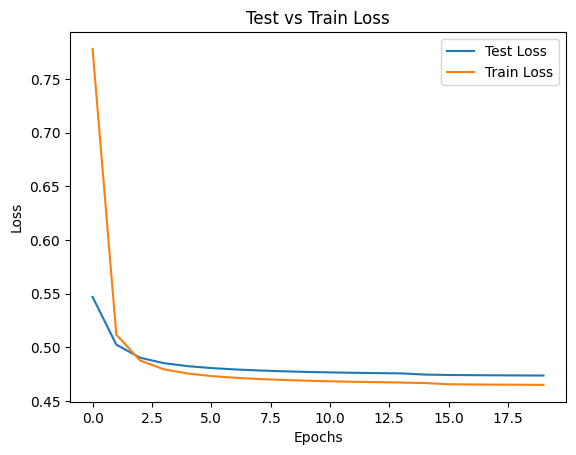

In [ ]:
# Affichage des courbes de la loss pour le train et le test

plt.plot(list_loss_test, label='Test Loss')
plt.plot(list_loss_train, label='Train Loss')

plt.title('Test vs Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

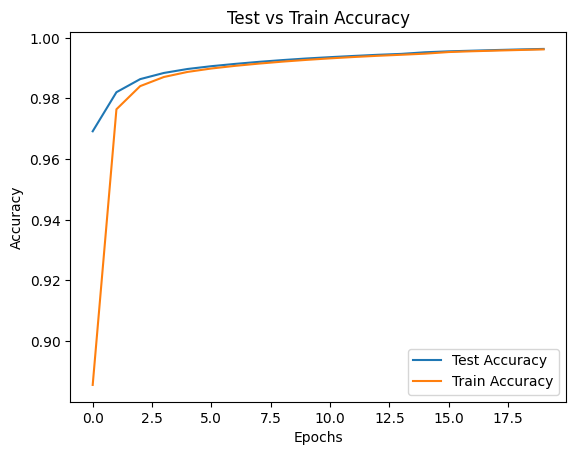

In [ ]:
# Affichage des courbes de l'accuracy pour le train et le test

plt.plot(list_accuracy_test, label='Test Accuracy')
plt.plot(list_accuracy_train, label='Train Accuracy')

plt.title('Test vs Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

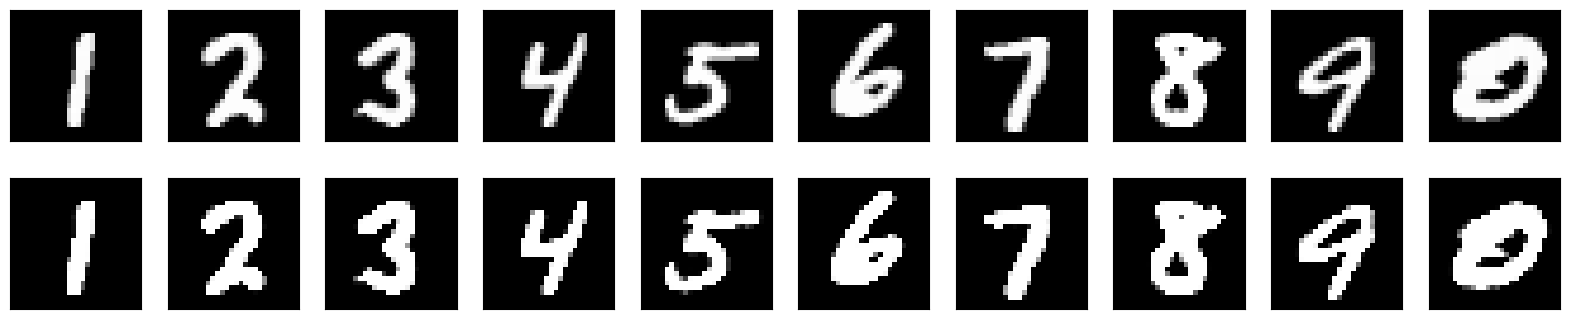

In [ ]:
# Affichage des chiffres avant encodage et après décodage

n = 10

plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()